In [1]:
import pickle

import torch
import numpy as np

from utils import get_datasets, run_experiments, visualise_experiments, visualise_most_and_least_informative_samples, get_info_and_predictions

from acquisition_functions import get_experiments
from acquisition_functions import predictive_entropy, mutual_information, variation_ratios, mean_standard_deviation, random

from networks import LeNet

torch.use_deterministic_algorithms(mode=True)

SEED = 1
MODEL_SAVE_PATH = '/Users/pascalpilz/Documents/Bsc Thesis/models/'
EXPERIMENT_SAVE_PATH = './Experiment Results/'

# Active Learning Experiments

In [2]:
experiments = get_experiments(which_acq_funcs=['predictive_entropy',
                                               'mutual_information',
                                               'variation_ratios',
                                               'mean_standard_deviation',
                                               'random'
                                               ],
                              n_acquisition_steps=10,
                              n_samples_to_acquire=10,
                              pool_subset_size=5_000,
                              test_subset_size=2_000,
                              T=64,
                              n_epochs=200,
                              early_stopping=-1,
                              val_size=1_000,
                              n_runs=1,
                              seed=SEED,)

experiment_results, save_path = run_experiments(experiments)

Experiments:   0%|          | 0/1 [00:00<?, ?it/s]

Runs per Experiment:   0%|          | 0/1 [00:00<?, ?it/s]

Acquisition Steps for Predictive Entropy:   0%|          | 0/11 [00:00<?, ?it/s]

Training Model with Training size 20: 0it [00:00, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

Training Model with Training size 30: 0it [00:00, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

Training Model with Training size 40: 0it [00:00, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

Training Model with Training size 50: 0it [00:00, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

Training Model with Training size 60: 0it [00:00, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

Training Model with Training size 70: 0it [00:00, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

Training Model with Training size 80: 0it [00:00, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

Training Model with Training size 90: 0it [00:00, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

Training Model with Training size 100: 0it [00:00, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

Training Model with Training size 110: 0it [00:00, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

Training Model with Training size 120: 0it [00:00, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

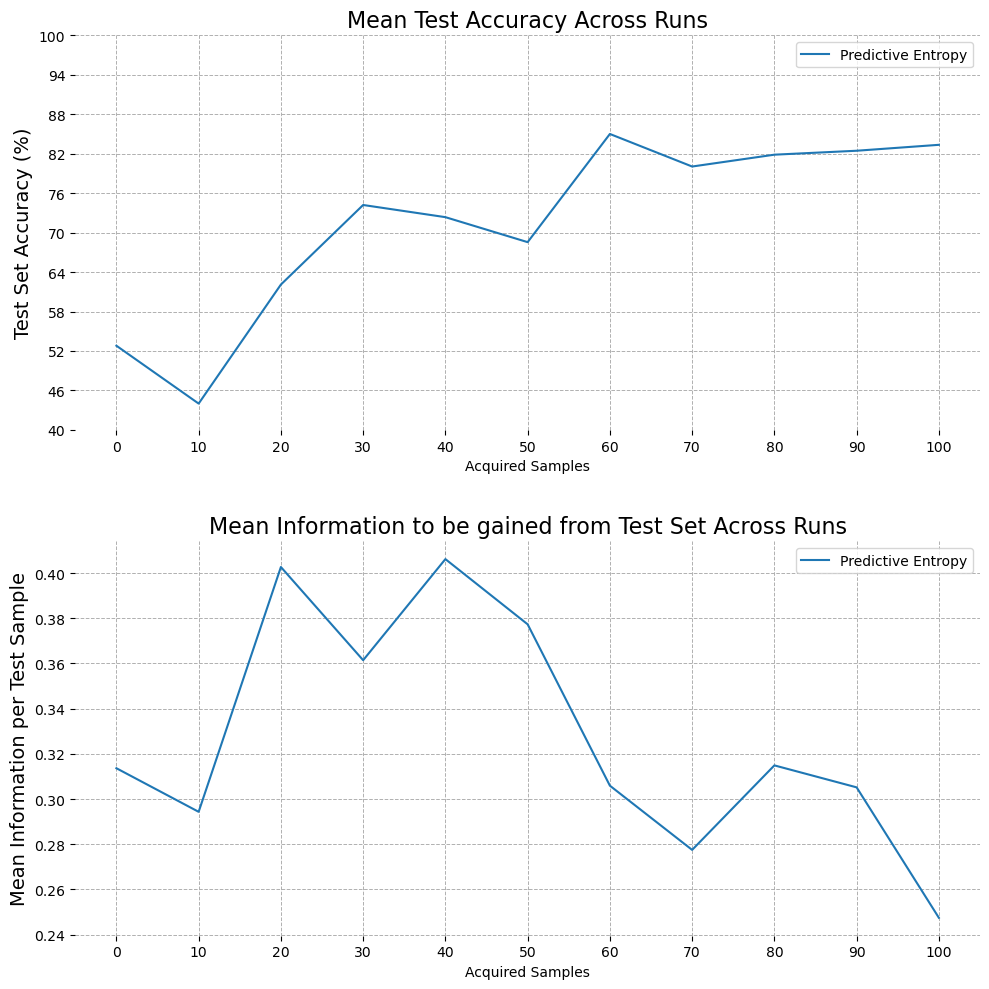

In [5]:
# save_path = EXPERIMENT_SAVE_PATH + 'expID-20240914_171842'
with open(save_path, 'rb') as handle:
    loaded_experiment_results = pickle.load(handle)

visualise_experiments(loaded_experiment_results)

# Getting Most and Least Informative Samples per Acquisition Function

In [4]:
X_train, y_train, X_pool, y_pool, X_val, y_val, X_test, y_test = get_datasets()

subset_idx = np.random.choice(range(X_pool.shape[0]), size=1_000, replace=False)
X_pool_subset = X_pool[subset_idx]
y_pool_subset = y_pool[subset_idx]

In [6]:
path = MODEL_SAVE_PATH + 'expID-20240909_184325/run-0/mutual_information/trainsize-00960_epoch-0119_valloss-0.123'
model = LeNet()
model.load_state_dict(torch.load(path, weights_only=True))

<All keys matched successfully>

MC Dropout:   0%|          | 0/10 [00:00<?, ?it/s]

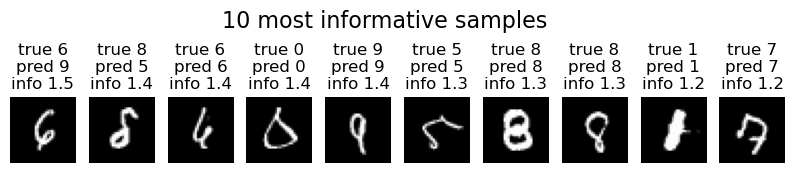

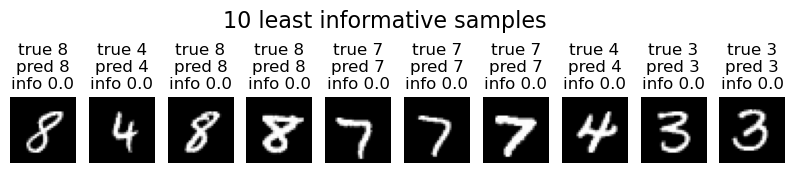

In [7]:
infos, preds, subset_idx\
    = get_info_and_predictions(model, X_pool_subset, show_pbar=True,
                               acquisition_function=predictive_entropy)
visualise_most_and_least_informative_samples(infos, preds,
                                             X_pool_subset, y_pool_subset)

MC Dropout:   0%|          | 0/10 [00:00<?, ?it/s]

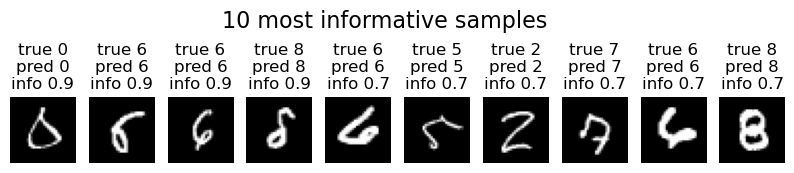

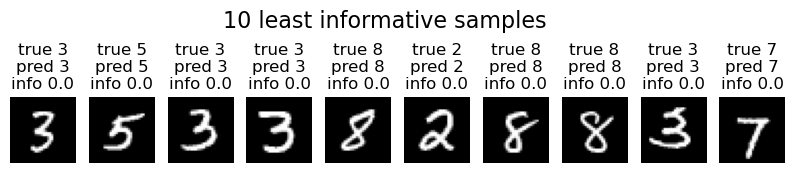

In [8]:
infos, preds, subset_idx\
    = get_info_and_predictions(model, X_pool_subset, show_pbar=True,
                               acquisition_function=mutual_information)
visualise_most_and_least_informative_samples(infos, preds,
                                             X_pool_subset, y_pool_subset)

MC Dropout:   0%|          | 0/10 [00:00<?, ?it/s]

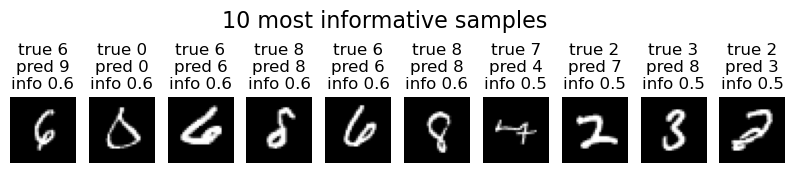

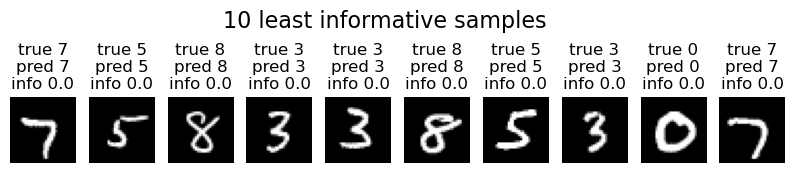

In [9]:
infos, preds, subset_idx\
    = get_info_and_predictions(model, X_pool_subset, show_pbar=True,
                               acquisition_function=variation_ratios)
visualise_most_and_least_informative_samples(infos, preds,
                                             X_pool_subset, y_pool_subset)

MC Dropout:   0%|          | 0/10 [00:00<?, ?it/s]

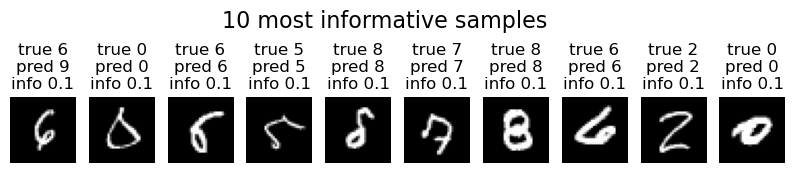

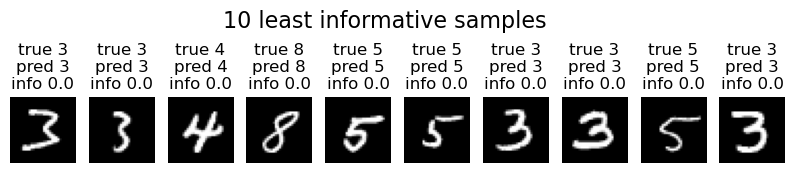

In [10]:
infos, preds, subset_idx\
    = get_info_and_predictions(model, X_pool_subset, show_pbar=True,
                               acquisition_function=mean_standard_deviation)
visualise_most_and_least_informative_samples(infos, preds,
                                             X_pool_subset, y_pool_subset)

MC Dropout:   0%|          | 0/10 [00:00<?, ?it/s]

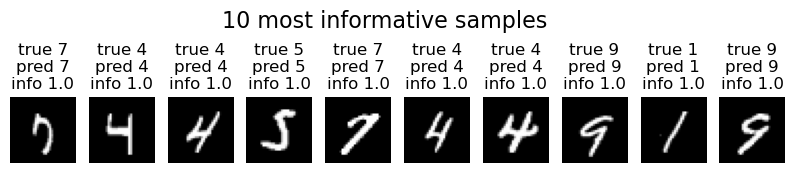

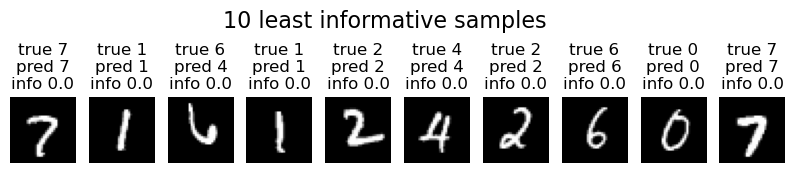

In [11]:
infos, preds, subset_idx\
    = get_info_and_predictions(model, X_pool_subset, show_pbar=True,
                               acquisition_function=random)
visualise_most_and_least_informative_samples(infos, preds,
                                             X_pool_subset, y_pool_subset)